# EEG PreProcessing for Hyper Alignment Project

Try stuff. 

In [107]:
%matplotlib inline

import os
import csv
from collections import Counter

import numpy as np
import matplotlib.pyplot as plt

import mne

# MNE associated & pre-processing code
from mne.preprocessing import ICA
#from autoreject import AutoReject

# Classification stuff
from sklearn import svm
from sklearn.model_selection import cross_val_score, LeaveOneOut

In [65]:
# ## Functions
# def org_files(files):
#     """Get the preprocessed, EEG data file names (csv format) a specified subject."""

#     eeg = [fi for fi in files if 'events' not in fi]
#     evs = [fi for fi in files if 'events' in fi]

#     # Quick hack to ignore subjs with problematic files
#     if not len(eeg) == len(evs):
#         print('Oh Shit. Something seems to have gone wrong.')
#         return None, None

#     return eeg, evs

def get_files(files, num):
    """Return specified file type from list of files.
    Note: scrappy implementation - returns only first found file that matches pattern. 
    """
    
    for file in files:
        if num in file:
            return file

## Settings


In [66]:
# Settings


## Load Data

Dataset description:

The EEG data used is a database collected and made available by the Child Mind Institute.

It is part of the Multimodal Resource for Studying Information Processing in the Developing Brain (MIPDB) database.

MIPDB Link: http://fcon_1000.projects.nitrc.org/indi/cmi_eeg/

EEG Data Link: http://fcon_1000.projects.nitrc.org/indi/cmi_eeg/eeg.html

In [67]:
# Set data path
dat_path = '/Users/tom/Desktop/HyperEEG_Project/Data/'
# ToDo: general stuff to get a list of available subjects

In [68]:
# Set subject to load
sub_num = 'A00062165'
subj_path = os.path.join(dat_path, sub_num, 'EEG', 'raw', 'raw_format')

In [69]:
# Get list of subject files
subj_files = os.listdir(subj_path)

# Restrict to only data files (avoids hidden files, etc)
subj_files = [file for file in subj_files if 'A0' in file]

In [72]:
# Get specific block
#  Note: want to start with contrast change detection: '006', 008', '010'
f_type = '08'
cur_eeg_file = get_files(subj_files, f_type)

In [74]:
# Load subject of data
raw = mne.io.read_raw_egi(os.path.join(subj_path, cur_eeg_file), preload=True)

Reading EGI header from /Users/tom/Desktop/HyperEEG_Project/Data/A00062165/EEG/raw/raw_format/A00062165008.raw...
    Reading events ...
    Assembling measurement info ...
    Synthesizing trigger channel "STI 014" ...
    Excluding events {101 , 102 , 103 , 104 , 106 , 108 , 109 , 11  , 14  , 15  , 16  , 17  , 18  , 20  , 21  , 22  , 23  , 24  , 25  , 26  , 27  , 28  , 30  , 31  , 32  , 33  , 34  , 35  , 4   , 50  , 81  , 82  , 83  , 84  , 86  , 90  , 91  , 92  , 93  , 94  , 95  , 96  , 97  , 98  , 99  , 9999} ...
Reading 0 ... 149402  =      0.000 ...   298.804 secs...


In [77]:
# Sanity check consistency
event_mapping = {'12  ': 1, '13  ': 2, '5   ': 3, '8   ': 4, '9   ': 5}
if raw.event_id != event_mapping:
    print(raw.event_id)
    raise ValueError("WARNING: event mapping issue.")

In [78]:
# Check event codes present from the file
set(mne.find_events(raw)[:, 2])

73 events found
Event IDs: [1 2 3 4 5]


{1, 2, 3, 4, 5}

## Set up Data


### Montage

In [79]:
# ToDo: Solve the E129 mystery
#  Note: this might be easier to load the channel file packaged with the dataset

In [80]:
# Load standard montage
montage = mne.channels.read_montage('GSN-HydroCel-129', ch_names=raw.ch_names)
raw.set_montage(montage)

# Hack for 129
raw.set_channel_types({'E129': 'misc'})

The following EEG sensors did not have a position specified in the selected montage: ['E129']. Their position has been left untouched.


<ipython-input-80-c0208ecd5fea>:3: RuntimeWarning: The following EEG sensors did not have a position specified in the selected montage: ['E129']. Their position has been left untouched.
  raw.set_montage(montage)


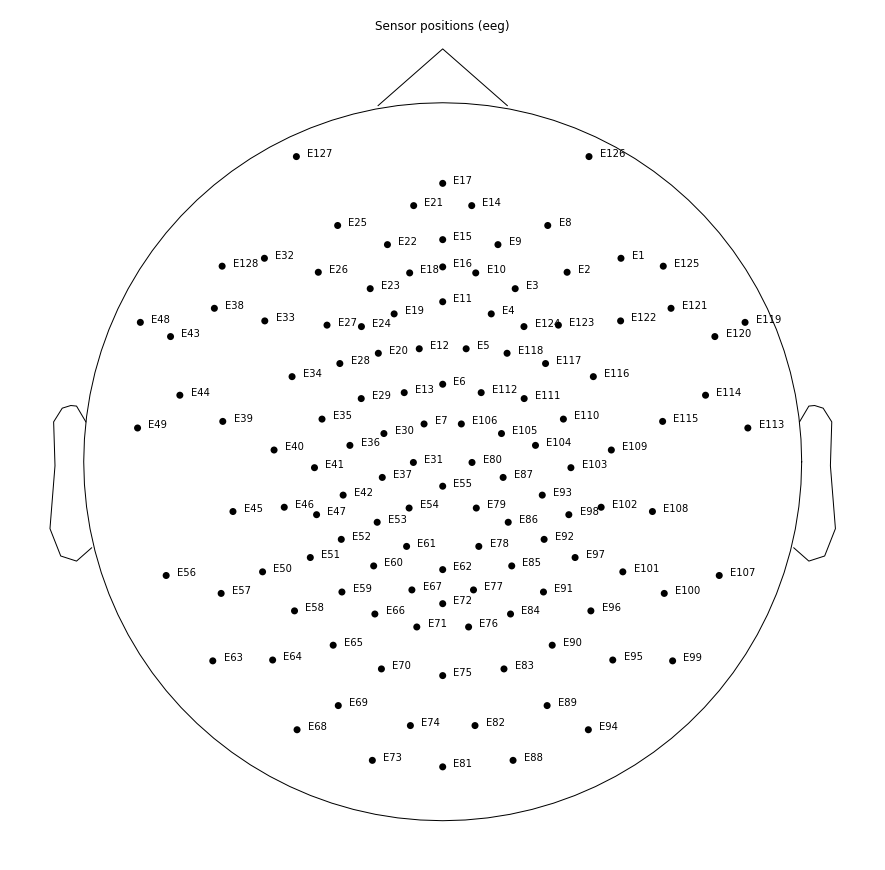

In [50]:
# Check channel locations
fig, ax = plt.subplots(figsize=[12, 12]);
raw.plot_sensors(show_names=True, axes=ax);

## Sanity Check Data

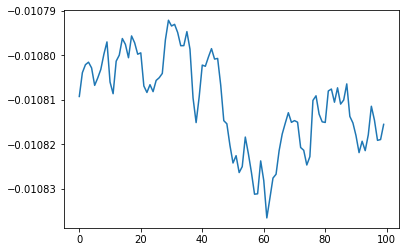

In [83]:
# Print out a small snippet of data
plt.plot(raw._data[0, 0:100])

Effective window size : 4.096 (s)


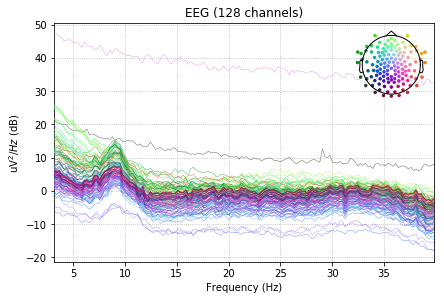

In [84]:
# Check the power spectrum of each channel
raw.plot_psd(tmin=10, fmin=3, fmax=40);

In [55]:
#raw.plot_psd_topo();

## Pre-Processing

Run pre-processing on the data. 

In [56]:
# ToDo: Detect & mark bad channels procedure

In [57]:
# Referencing
raw.set_eeg_reference()

Applying average reference.
Applying a custom EEG reference.


<RawEGI  |  A00062165008.raw, n_channels x n_times : 181 x 149403 (298.8 sec), ~206.7 MB, data loaded>

### ICA

Note: can run ICA and automatically rejet eye from corralation with very frontal channels: E127. E126

In [58]:
# High pass filter for ICA
raw.filter(l_freq=1., h_freq=None, fir_design='firwin')

Setting up high-pass filter at 1 Hz
l_trans_bandwidth chosen to be 1.0 Hz
Filter length of 1651 samples (3.302 sec) selected


<RawEGI  |  A00062165008.raw, n_channels x n_times : 181 x 149403 (298.8 sec), ~206.7 MB, data loaded>

In [59]:
# ICA Settings
method = 'fastica'

n_components = None
random_state = 47
decim = None
reject = {'eeg': 25e-4}

In [60]:
# Initialize ICA object
ica = ICA(n_components=n_components, method=method, random_state=random_state)

In [61]:
# Fit ICA
ica.fit(raw, decim=decim, reject=reject)

Fitting ICA to data using 128 channels (please be patient, this may take a while)
Inferring max_pca_components from picks
    Rejecting  epoch based on EEG : ['E104']
Artifact detected in [1000, 2000]
    Rejecting  epoch based on EEG : ['E104']
Artifact detected in [4000, 5000]
    Rejecting  epoch based on EEG : ['E104']
Artifact detected in [6000, 7000]
    Rejecting  epoch based on EEG : ['E104']
Artifact detected in [11000, 12000]
    Rejecting  epoch based on EEG : ['E104']
Artifact detected in [12000, 13000]
    Rejecting  epoch based on EEG : ['E104']
Artifact detected in [13000, 14000]
    Rejecting  epoch based on EEG : ['E104']
Artifact detected in [15000, 16000]
    Rejecting  epoch based on EEG : ['E104']
Artifact detected in [16000, 17000]
    Rejecting  epoch based on EEG : ['E104']
Artifact detected in [17000, 18000]
    Rejecting  epoch based on EEG : ['E104']
Artifact detected in [19000, 20000]
    Rejecting  epoch based on EEG : ['E104']
Artifact detected in [20000, 

    Rejecting  epoch based on EEG : ['E104']
Artifact detected in [128000, 129000]
    Rejecting  epoch based on EEG : ['E104']
Artifact detected in [129000, 130000]
    Rejecting  epoch based on EEG : ['E104']
Artifact detected in [130000, 131000]
    Rejecting  epoch based on EEG : ['E104']
Artifact detected in [131000, 132000]
    Rejecting  epoch based on EEG : ['E104']
Artifact detected in [132000, 133000]
    Rejecting  epoch based on EEG : ['E104']
Artifact detected in [133000, 134000]
    Rejecting  epoch based on EEG : ['E104']
Artifact detected in [134000, 135000]
    Rejecting  epoch based on EEG : ['E104']
Artifact detected in [135000, 136000]
    Rejecting  epoch based on EEG : ['E104']
Artifact detected in [136000, 137000]
    Rejecting  epoch based on EEG : ['E104']
Artifact detected in [137000, 138000]
    Rejecting  epoch based on EEG : ['E104']
Artifact detected in [138000, 139000]
    Rejecting  epoch based on EEG : ['E104']
Artifact detected in [139000, 140000]
    

<ICA  |  raw data decomposition, fit (fastica): 29000 samples, 10 components, channels used: "eeg">

In [62]:
# You can now use the ICA solution to find EOG related components
inds, scores = ica.find_bads_eog(raw, ch_name='E126')

Using channel E126 as EOG channel
... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz
Filter length of 8192 samples (16.384 sec) selected
... filtering target
Setting up band-pass filter from 1 - 10 Hz
Filter length of 8192 samples (16.384 sec) selected


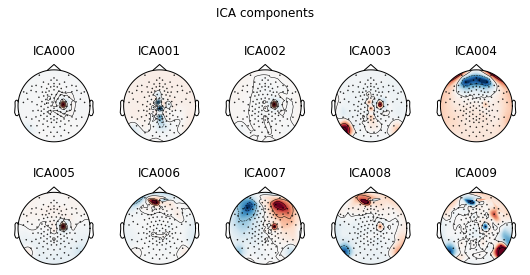

In [63]:
# Plot the ICA components
ica.plot_components()

In [27]:
# Save out the ICA solution
#ica.save()

### Filtering

In [120]:
# Filter setting
low_freq = 1
high_freq = 20

In [121]:
# Filter EEG data
raw.filter(l_freq=low_freq, h_freq=high_freq, fir_design='firwin')

Setting up band-pass filter from 1 - 20 Hz
l_trans_bandwidth chosen to be 1.0 Hz
h_trans_bandwidth chosen to be 5.0 Hz
Filter length of 1651 samples (3.302 sec) selected


<RawEGI  |  A00062165008.raw, n_channels x n_times : 181 x 149403 (298.8 sec), ~206.7 MB, data loaded>

### Events & Epoching

Event code descriptions:
- 3 :  5  = start trial
- 4 :  8  = Target ON left
- 5 :  9  = Target ON right
- 1 : 12  = button press left
- 2 : 13  = button press right

In [122]:
# Check how many of each event
Counter(dat_evs[:, 2])

Counter({1: 14, 2: 10, 3: 25, 4: 12, 5: 12})

In [123]:
# Check event code mapping
raw.event_id

{'12  ': 1, '13  ': 2, '5   ': 3, '8   ': 4, '9   ': 5}

In [124]:
# Check events
dat_evs = mne.find_events(raw)

73 events found
Event IDs: [1 2 3 4 5]


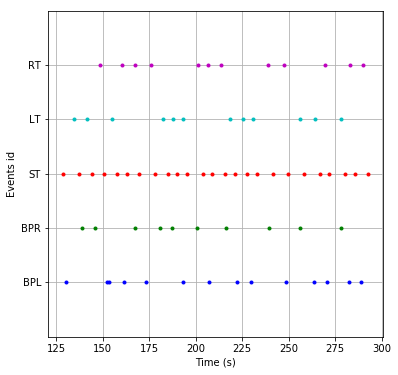

In [125]:
# Check event codes
fig, ax = plt.subplots(figsize=[6, 6])
_ = mne.viz.plot_events(dat_evs, raw.info['sfreq'], axes=ax, show=False)
ax.set_yticklabels(['BPL', 'BPR', 'ST', 'LT', 'RT']);

In [126]:
# Epoch settings
tmin, tmax = -1, 1

# Event code descriptions
targets = [4, 5]
respons = [1, 2]

In [132]:
# Epoch data
epochs = mne.Epochs(raw, dat_evs, event_id=targets)

24 matching events found
Applying baseline correction (mode: mean)
Not setting metadata
0 projection items activated


Loading data for 24 events and 351 original time points ...
0 bad epochs dropped
Loading data for 20 events and 351 original time points ...


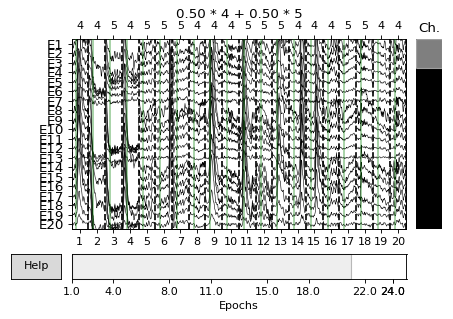

In [133]:
# Sanity check event time series
epochs.plot();

### AutoReject

Note: only works on epoched trials

In [134]:
# Initialize autoreject object
#ar = AutoReject()

In [135]:
# Run AutoReject
#epochs, rej_log = ar.fit_transform(epochs, True)

# Analyses

At this point, the rest becomes specific to the particular analyses that need to be done.

In [136]:
# Calcualte ERPs
evoked = epochs.average()

time_unit defaults to "ms" in 0.16 but will change to "s" in 0.17, set it explicitly to avoid this warning


<ipython-input-137-ef333a697218>:2: DeprecationWarning: time_unit defaults to "ms" in 0.16 but will change to "s" in 0.17, set it explicitly to avoid this warning
  evoked.plot();


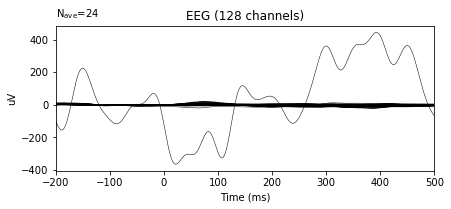

In [137]:
# Plot ERPs
evoked.plot();

time_unit defaults to "ms" in 0.16 but will change to "s" in 0.17, set it explicitly to avoid this warning


<ipython-input-138-48b118bafdda>:2: DeprecationWarning: time_unit defaults to "ms" in 0.16 but will change to "s" in 0.17, set it explicitly to avoid this warning
  evoked.plot_topomap([-0.1, 0, 0.200, 0.4]);


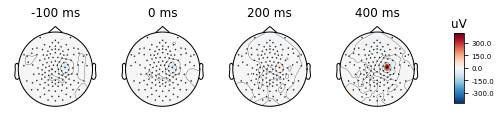

In [138]:
# Check topographies across time
evoked.plot_topomap([-0.1, 0, 0.200, 0.4]);

# Classification

Decode both to the stimulus, and to the response.

In [ ]:
# SVM Classification, on analytic amplitude of alpha data
clf = svm.SVC(kernel='linear')

In [ ]:
#data = ...
#labels = ...

In [ ]:
scores = cross_val_score(clf, data, labels, cv=5)